In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from datetime import datetime
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, precision_score, recall_score
from sklearn.utils import shuffle
from transformers import pipeline
from gensim.models.keyedvectors import KeyedVectors
import pickle, json
from utils.helpers import *
from transformers import BertTokenizer, BertModel
import torch

In [1]:
handlabel_augmented = pd.read_csv('../data/handlabel_augmented.csv').dropna().reset_index(drop=True)

In [3]:
handlabel_augmented.shape

(3087, 9)

In [4]:
labels = ['communication', 'waiting time',
       'information', 'user interface',
       'facilities', 'location', 'price']

# Load BERT

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Vectorize text
handlabel_vectorized = preprocess_bert(model, tokenizer, handlabel_augmented, batch_size=1)

Batch 0 started at 09-03-2022 18:57:17
Batch 100 started at 09-03-2022 18:59:57
Batch 200 started at 09-03-2022 19:02:19
Batch 300 started at 09-03-2022 19:04:44
Batch 400 started at 09-03-2022 19:07:09
Batch 500 started at 09-03-2022 19:09:35
Batch 600 started at 09-03-2022 19:12:00
Batch 700 started at 09-03-2022 19:14:26
Batch 800 started at 09-03-2022 19:16:54
Batch 900 started at 09-03-2022 19:19:19
Batch 1000 started at 09-03-2022 19:21:45
Batch 1100 started at 09-03-2022 19:24:14
Batch 1200 started at 09-03-2022 19:26:39
Batch 1300 started at 09-03-2022 19:29:05
Batch 1400 started at 09-03-2022 19:31:31
Batch 1500 started at 09-03-2022 19:33:57
Batch 1600 started at 09-03-2022 19:36:28
Batch 1700 started at 09-03-2022 19:38:51
Batch 1800 started at 09-03-2022 19:41:12
Batch 1900 started at 09-03-2022 19:43:35
Batch 2000 started at 09-03-2022 19:45:55
Batch 2100 started at 09-03-2022 19:48:19
Batch 2200 started at 09-03-2022 19:50:43
Batch 2300 started at 09-03-2022 19:53:07
Batc

In [7]:
handlabel_vectorized.to_csv('../data/untuned_bert_handlabel_augmented.csv', index=False)

In [8]:
X = handlabel_vectorized[range(768)]
y = handlabel_vectorized[labels]

# Use original text as test set, synthetic text as training set

In [9]:
X_train = X.loc[227:]
y_train = y.loc[227:]
X_test = X.loc[:226]
y_test = y.loc[:226]

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

Text(0.5, 1.0, 'y_test')

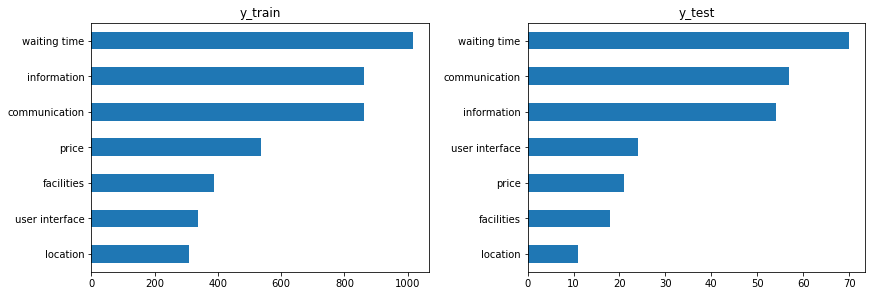

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), constrained_layout=True)

y_train[labels].sum().sort_values().plot(kind='barh', ax=ax[0])
ax[0].set_title('y_train')

y_test[labels].sum().sort_values().plot(kind='barh', ax=ax[1])
ax[1].set_title('y_test')

In [12]:
y_test.shape

(227, 7)

In [13]:
y_train.shape

(2860, 7)

In [14]:
ovr_svc = OneVsRestClassifier(SVC(probability=True, class_weight='balanced'))
ovr_rfc = OneVsRestClassifier(RandomForestClassifier(max_depth=5, class_weight='balanced_subsample'))
ovr_mlp = OneVsRestClassifier(MLPClassifier(early_stopping=True, hidden_layer_sizes=(64,32,8)))

In [15]:
get_scores(ovr_svc, X_train, y_train, X_test, y_test)

------------TRAINING DATASET RESULTS (OneVsRestClassifier(estimator=SVC(class_weight='balanced', probability=True)))------------


                precision    recall  f1-score   support

 communication       0.81      0.90      0.85       861
  waiting time       0.80      0.93      0.86      1016
   information       0.83      0.91      0.87       863
user interface       0.65      0.96      0.77       336
    facilities       0.78      0.97      0.86       387
      location       0.82      0.98      0.89       308
         price       0.85      0.95      0.90       535

     micro avg       0.80      0.93      0.86      4306
     macro avg       0.79      0.94      0.86      4306
  weighted avg       0.80      0.93      0.86      4306
   samples avg       0.80      0.92      0.84      4306

------------TEST DATASET RESULTS (OneVsRestClassifier(estimator=SVC(class_weight='balanced', probability=True)))------------


                precision    recall  f1-score   support

 communica

In [16]:
get_scores(ovr_rfc, X_train, y_train, X_test, y_test)

------------TRAINING DATASET RESULTS (OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=5)))------------


                precision    recall  f1-score   support

 communication       0.86      0.88      0.87       861
  waiting time       0.86      0.95      0.90      1016
   information       0.86      0.88      0.87       863
user interface       0.76      0.94      0.84       336
    facilities       0.93      0.98      0.95       387
      location       0.92      0.94      0.93       308
         price       0.90      0.94      0.92       535

     micro avg       0.87      0.92      0.89      4306
     macro avg       0.87      0.93      0.90      4306
  weighted avg       0.87      0.92      0.89      4306
   samples avg       0.84      0.90      0.86      4306

------------TEST DATASET RESULTS (OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsamp

In [17]:
get_scores(ovr_mlp, X_train, y_train, X_test, y_test)

------------TRAINING DATASET RESULTS (OneVsRestClassifier(estimator=MLPClassifier(early_stopping=True,
                                            hidden_layer_sizes=(64, 32, 8))))------------


                precision    recall  f1-score   support

 communication       0.98      0.97      0.98       861
  waiting time       0.94      0.97      0.96      1016
   information       0.99      0.98      0.98       863
user interface       0.98      0.93      0.96       336
    facilities       0.92      0.80      0.86       387
      location       1.00      0.96      0.98       308
         price       1.00      0.98      0.99       535

     micro avg       0.97      0.95      0.96      4306
     macro avg       0.97      0.94      0.96      4306
  weighted avg       0.97      0.95      0.96      4306
   samples avg       0.94      0.94      0.94      4306

------------TEST DATASET RESULTS (OneVsRestClassifier(estimator=MLPClassifier(early_stopping=True,
                               

# Apply PCA to reduce dimensions

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=768)

p_comps = pca.fit_transform(X_train)

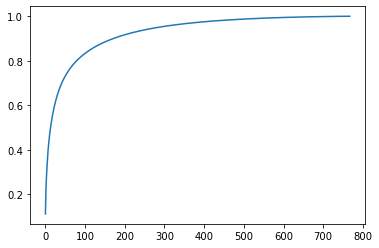

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [21]:
np.sum(np.cumsum(pca.explained_variance_ratio_) <= 0.95)

284

In [22]:
pca = PCA(n_components=296)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit on PCA transformed

In [23]:
get_scores(ovr_svc, X_train_pca, y_train, X_test_pca, y_test)

------------TRAINING DATASET RESULTS (OneVsRestClassifier(estimator=SVC(class_weight='balanced', probability=True)))------------


                precision    recall  f1-score   support

 communication       0.96      0.99      0.97       861
  waiting time       0.93      0.99      0.96      1016
   information       0.98      0.97      0.98       863
user interface       0.95      1.00      0.98       336
    facilities       0.97      1.00      0.98       387
      location       1.00      1.00      1.00       308
         price       0.98      1.00      0.99       535

     micro avg       0.96      0.99      0.98      4306
     macro avg       0.97      0.99      0.98      4306
  weighted avg       0.96      0.99      0.98      4306
   samples avg       0.96      0.99      0.97      4306

------------TEST DATASET RESULTS (OneVsRestClassifier(estimator=SVC(class_weight='balanced', probability=True)))------------


                precision    recall  f1-score   support

 communica

In [24]:
get_scores(ovr_rfc, X_train_pca, y_train, X_test_pca, y_test)

------------TRAINING DATASET RESULTS (OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=5)))------------


                precision    recall  f1-score   support

 communication       0.91      0.91      0.91       861
  waiting time       0.89      0.96      0.93      1016
   information       0.97      0.91      0.94       863
user interface       0.93      0.97      0.95       336
    facilities       0.98      0.97      0.97       387
      location       1.00      0.94      0.97       308
         price       0.93      0.94      0.94       535

     micro avg       0.93      0.94      0.94      4306
     macro avg       0.94      0.94      0.94      4306
  weighted avg       0.93      0.94      0.94      4306
   samples avg       0.90      0.93      0.91      4306

------------TEST DATASET RESULTS (OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsamp

In [25]:
get_scores(ovr_mlp, X_train_pca, y_train, X_test_pca, y_test)

------------TRAINING DATASET RESULTS (OneVsRestClassifier(estimator=MLPClassifier(early_stopping=True,
                                            hidden_layer_sizes=(64, 32, 8))))------------


                precision    recall  f1-score   support

 communication       0.98      0.98      0.98       861
  waiting time       0.99      0.98      0.99      1016
   information       0.99      0.98      0.99       863
user interface       1.00      0.89      0.94       336
    facilities       0.99      0.98      0.98       387
      location       1.00      0.97      0.99       308
         price       0.99      0.95      0.97       535

     micro avg       0.99      0.97      0.98      4306
     macro avg       0.99      0.96      0.98      4306
  weighted avg       0.99      0.97      0.98      4306
   samples avg       0.96      0.96      0.96      4306

------------TEST DATASET RESULTS (OneVsRestClassifier(estimator=MLPClassifier(early_stopping=True,
                               

# Save best model

In [26]:
ovr_svc_bert_untuned_pca = OneVsRestClassifier(SVC(probability=True, class_weight='balanced'))

In [27]:
get_scores(ovr_svc_bert_untuned_pca, X_train_pca, y_train, X_test_pca, y_test)

------------TRAINING DATASET RESULTS (OneVsRestClassifier(estimator=SVC(class_weight='balanced', probability=True)))------------


                precision    recall  f1-score   support

 communication       0.96      0.99      0.97       861
  waiting time       0.93      0.99      0.96      1016
   information       0.98      0.97      0.98       863
user interface       0.95      1.00      0.98       336
    facilities       0.97      1.00      0.98       387
      location       1.00      1.00      1.00       308
         price       0.98      1.00      0.99       535

     micro avg       0.96      0.99      0.98      4306
     macro avg       0.97      0.99      0.98      4306
  weighted avg       0.96      0.99      0.98      4306
   samples avg       0.96      0.99      0.97      4306

------------TEST DATASET RESULTS (OneVsRestClassifier(estimator=SVC(class_weight='balanced', probability=True)))------------


                precision    recall  f1-score   support

 communica

In [28]:
pickle.dump(ovr_svc_bert_untuned_pca, open('../models/bert_untuned_ovr_svc.sav', 'wb'))

In [29]:
pickle.dump(pca, open('../models/pca_bert_untuned.sav', 'wb'))